In [83]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import PIL
import librosa

import numpy as np

from skimage.io import imread
from collections import namedtuple
import matplotlib.pyplot as plt
from IPython.display import display as dis, Audio


from cs7643.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

## Helper Functions

In [84]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Variable of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Variable of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [85]:
class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            self.cnn1 = nn.Conv1d(in_channels=128, out_channels=4096, kernel_size=3, stride=1, padding=1)

        def forward(self, x):
            out = self.cnn1(x)
            out = out.view(out.size(0),-1)
            return out

## Content Loss

In [86]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    ##############################################################################
    difference = (content_current - content_original) ** 2
    out = content_weight * torch.sum(difference)
    return out

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Style Loss

In [87]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Variable of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Variable of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    #                                                                            #
    # HINT: you may find torch.bmm() function is handy when it comes to process  #
    # matrix product in a batch. Please check the document about how to use it.  #
    ##############################################################################
    N, C, H, W = features.shape
    reduced_F = features.view((N, C, H*W))
    
    mult = torch.bmm(reduced_F, reduced_F.permute((0, 2, 1)))
    if normalize:
        mult /= (C * reduced_F.shape[2])
    return mult
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################


In [88]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, all_style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Variable giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Variable holding a scalar giving the style loss.
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    #                                                                            #
    # Hint:                                                                      #
    # you can do this with one for loop over the style layers, and should not be #
    # very much code (~5 lines). Please refer to the 'style_loss_test' for the   #
    # actual data structure.                                                     #
    #                                                                            #
    # You will need to use your gram_matrix function.                            #
    ##############################################################################
    loss = 0.0
    for style_targets in all_style_targets:
        for ndx in range(len(style_layers)):
            currGram = gram_matrix(feats[style_layers[ndx]])
            diffGrams = (currGram - style_targets[ndx]) ** 2
            loss = loss + (style_weights[ndx] * torch.sum(diffGrams))
            
    loss = loss / len(all_style_targets)
    return Variable(torch.tensor(loss))
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Total-variation Regularization

In [89]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Please pay attention to use torch tensor math function to finish it.       #
    # Otherwise, you may run into the issues later that dynamic graph is broken  #
    # and gradient can not be derived.                                           #
    ##############################################################################
    loss = tv_weight * (torch.sum((img[:,:,:-1,:] - img[:,:,1:,:])**2) + torch.sum((img[:,:,:,:-1] - img[:,:,:,1:])**2))
    return Variable(loss)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Style Transfer

In [90]:
cnn = torchvision.models.vgg16(pretrained=True).features
cnn.type(torch.FloatTensor)

# Fix the weights of the pretrained network
for param in cnn.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/hemanthc98/.cache/torch/checkpoints/vgg16-397923af.pth


In [94]:
def style_transfer_audio(content_image, style_images, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """

    y_con, sr_con = librosa.load(content_image)#librosa.util.example_audio_file())
    S_content = librosa.feature.melspectrogram(y=y_con, sr=sr_con, n_mels=128, fmax=8000)
    S_dB_content = librosa.power_to_db(S_content, ref=np.max)
    
    out_img_spec = spec_to_image(S_dB_content)
    im = PIL.Image.fromarray(out_img_spec)
    im = im.convert('RGB')
    content_img = preprocess(im, size=image_size)
    content_img_var = Variable(content_img.type(torch.FloatTensor))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()
    
    all_style_targets = []
    all_style_images = []
    for style_image in style_images:
        y_style, sr_style = librosa.load(style_image)#librosa.util.example_audio_file())
        S_style = librosa.feature.melspectrogram(y=y_style, sr=sr_style, n_mels=128, fmax=8000)
        S_dB_style = librosa.power_to_db(S_style, ref=np.max)

        out_img_spec = spec_to_image(S_dB_style)
        im = PIL.Image.fromarray(out_img_spec)
        im = im.convert('RGB')
        style_img = preprocess(im, size=image_size)
        all_style_images.append(style_img)
        style_img_var = Variable(style_img.type(torch.FloatTensor))

        feats = extract_features(style_img_var, cnn)
        style_targets = []
        for idx in style_layers:
            style_targets.append(gram_matrix(feats[idx].clone()))
        all_style_targets.append(style_targets)
        

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone().type(torch.FloatTensor)

    # We do want the gradient computed on our image!
    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img_var Torch variable, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img_var], lr=initial_lr)
    
    print('Content Image')
    plt.axis('off')
    plt.imshow(deprocess(content_img.cpu()))
    plt.show()
    for i, style in enumerate(all_style_images):
        print('Style Image ' + str(i))
        plt.axis('off')
        plt.imshow(deprocess(style.cpu()))
        plt.show()
    
    for t in range(800):
        if t < 190:
            img.clamp_(-1.5, 1.5)
        feats = extract_features(img_var, cnn)

        ##############################################################################
        # TODO: Implement this update rule with by forwarding it to criterion        #
        # functions and perform the backward update.                                 #
        #                                                                            #
        # HINTS: all the weights, loss functions are defined. You don't need to add  # 
        # any other extra weights for the three loss terms.                          #
        # The optimizer needs to clear its grad before backward in every step.       #
        ##############################################################################
        optimizer.zero_grad()
        if t == decay_lr_at:
            for param_group in optimizer.param_groups:
                param_group['lr'] = decayed_lr
        
        content = content_loss(content_weight, feats[content_layer], content_target)
        style = style_loss(feats, style_layers, all_style_targets, style_weights)
        tv = tv_loss(img_var, tv_weight)
        
        all_loss = content + style + tv
        
        all_loss.backward()
        optimizer.step()

        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################        
        
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            print(all_loss.item())
            plt.axis('off')
            plt.imshow(deprocess(img.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    print(all_loss.item())
    plt.axis('off')
    plt.imshow(deprocess(img.cpu()))
    plt.show()
    return img.cpu()

## Running Style Transfer

Content Image


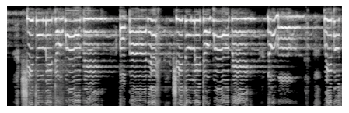

Style Image 0


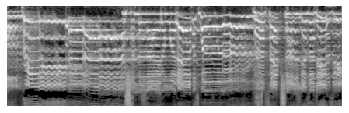

Style Image 1


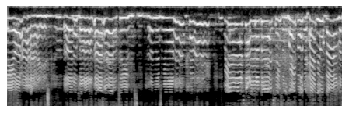

Style Image 2


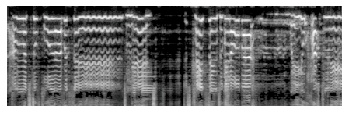

/Users/hemanthc98/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration 0
35072.14453125


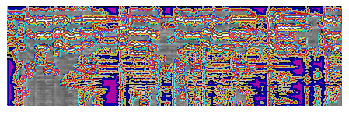

Iteration 100
35747.0546875


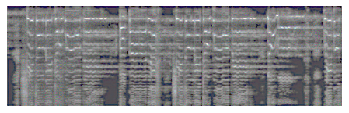

In [ ]:
params1 = {
    'content_image': "./weeknd_10sec_sample.wav",
    'style_images': ["./beyonce_10sec_sample.wav", "./beyonce_dang_love_10sec.wav", "./beyonce_resentment_10sec.wav"],
    'image_size' : 128,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

img_out = style_transfer_audio(**params1)

In [ ]:
outimg = img_out.squeeze().data.numpy()
deproc = deprocess(img_out)
deproc.save("weekend_bey_mult_vgg.png")
avgout = outimg.mean(axis=0)
y = librosa.feature.inverse.mel_to_audio(avgout, sr=22050)
librosa.output.write_wav('week_beyonce_mult_style_vgg.wav', y, 22050)
librosa.display.specshow(y, sr=22050)
dis(Audio(y, rate=22050))